In [31]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.tsa.api as sm
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as smm
import warnings
from pandas.plotting import autocorrelation_plot
#Set graph size
warnings.filterwarnings("ignore")
plt.rcParams['figure.figsize'] = [10, 5]
#import sales data
sales_data = pd.read_csv('data.csv')
sales_data.set_index('date',inplace=True)

## 1) Check if Time Series Data is Stationary

<Figure size 720x360 with 0 Axes>

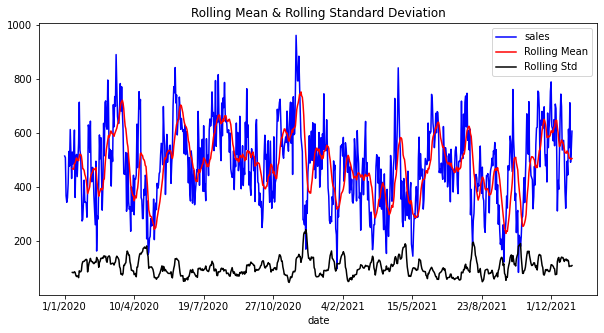

Statistical Test:
ADF test results:
Test Statistic         -7.626339e+00
p-value                 2.063917e-11
Critical Value (1%)    -3.439352e+00
Critical Value (5%)    -2.865513e+00
Critical Value (10%)   -2.568886e+00
dtype: float64


In [32]:
def check_stationary(sales_data): 
    #Visually check the stationarity
    plt.clf() 
    sales_data.plot(color = 'blue')
    rolling_mean = sales_data.rolling(window = 12).mean()
    rolling_std = sales_data.rolling(window = 12).std()
    plt.plot(rolling_mean, color = 'red', label = 'Rolling Mean')
    plt.plot(rolling_std, color = 'black', label = 'Rolling Std')
    plt.legend(loc = 'best')
    plt.title('Rolling Mean & Rolling Standard Deviation')
    plt.show()
    #ADF test
    print('Statistical Test:')
    print('ADF test results:')
    adftest = adfuller(sales_data)
    adfoutput = pd.Series(adftest[0:2], index=['Test Statistic','p-value'])
    for key,value in adftest[4].items():
        adfoutput['Critical Value (%s)'%key] = value
    print (adfoutput)

check_stationary(sales_data)

### Time Series Plot 
The lack of a clear trend or seasonality in the time series plot suggests that the time series is stationary.
### ADF Result
The p-value of the ADF test is less than 0.05. Thus, we can reject the null hypothesis and conclude that the time series does not have a unit root, meaning it is stationary. 

## 2) Determine ARIMA Order

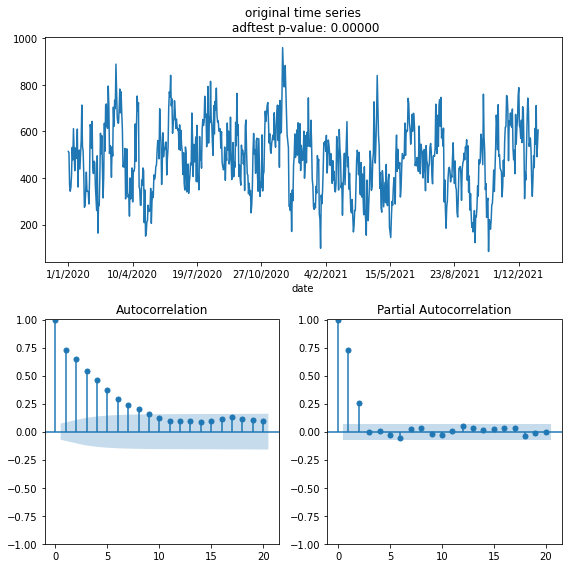

In [34]:
def my_plot(x, lags =20, alpha=0.05):
    ts = pd.Series(x)
    layout = (2,2)
    ts_ax = plt.subplot2grid(layout, (0,0),colspan = 2)
    acf_ax = plt.subplot2grid(layout, (1,0))
    pacf_ax = plt.subplot2grid(layout, (1,1))
    adf_test = adfuller(ts)[1]
    ts_ax.set_title('original time series\n adftest p-value: {:0.5f}'.format(adf_test))
    ts.plot(ax= ts_ax)
    sm.graphics.plot_acf(ts, ax =acf_ax, lags = lags, alpha =alpha)
    sm.graphics.plot_pacf(ts, ax =pacf_ax, lags = lags, alpha =alpha)
    plt.tight_layout()
    
    plt.show(block=False)
plt.rcParams['figure.figsize'] = [8, 8]
my_plot(sales_data['sales'])

### D
The p-value of the ADF test is less than 0.05 and thus show strong evidence against the null hypothesis. Thus, we can reject the existence of the unit root and conclude that the series is stationary. Thus, no differencing is required and d = 0

### AR/P
There seems to be a clear cutoff patern in PACF at lag 2. Thus p = 2

### MA/Q
There is no clear pattern in ACF. As there is no clear pattern in ACF, i will try different values to see which values yield the best result. Thus let q = 4


In [35]:
model = smm.tsa.ARIMA(sales_data["sales"], order=(2,0,4))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  sales   No. Observations:                  731
Model:                 ARIMA(2, 0, 4)   Log Likelihood               -4386.398
Date:                Fri, 04 Feb 2022   AIC                           8788.797
Time:                        14:09:42   BIC                           8825.552
Sample:                             0   HQIC                          8802.976
                                - 731                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        483.3975     16.995     28.443      0.000     450.087     516.708
ar.L1          0.8809      0.699      1.260      0.208      -0.490       2.251
ar.L2         -0.0650      0.588     -0.111      0.912      -1.218       1.088
ma.L1         -0.3330      0.696     -0.478      0.632      -1.698       1.032
ma.L2          0.1382      0.211      0.654      0.513      -0.276       0.553
ma.L3         -0.0132      0.078     -0.170      0.865      -0.165       0.139
ma.L4          0.0635      0.043      1.481      0.139      -0.021       0.148
sigma2      9558.8593    516.508     18.507      0.000    8546.521    1.06e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 1.37
Prob(Q):                              0.98   Prob(JB):                         0.50
Heteroskedasticity (H):               0.87   Skew:                             0.10
Prob(H) (two-sided):                  0.27   Kurtosis:                         2.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Configuring ARIMA Model

As the coefficient of the MA1-MA4 term is close to zero and their P-Value in P>|z| column is > 0.05,I will rebuild the model without those term



In [28]:
model = smm.tsa.ARIMA(sales_data["sales"], order=(2,0,0))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  sales   No. Observations:                  731
Model:                 ARIMA(2, 0, 0)   Log Likelihood               -4387.356
Date:                Fri, 04 Feb 2022   AIC                           8782.712
Time:                        14:00:27   BIC                           8801.090
Sample:                             0   HQIC                          8789.802
                                - 731                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        483.4145     17.960     26.916      0.000     448.213     518.616
ar.L1          0.5478      0.038     14.247      0.000       0.472       0.623
ar.L2          0.2499      0.038      6.633      0.000       0.176       0.324
sigma2      9552.1627    508.197     18.796      0.000    8556.115    1.05e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 1.34
Prob(Q):                              0.96   Prob(JB):                         0.51
Heteroskedasticity (H):               0.88   Skew:                             0.10
Prob(H) (two-sided):                  0.31   Kurtosis:                         2.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## ARIMA Model Result
 

#### Determine Term Significance
As the AR term have a p-value that is less than 0.05, I can conclude that the coefficient for the AR term is statistically significant and we should keep them in the model.

#### Review Assumptions
The p-value of Prob(Q) is 0.96. Since 0.96 > 0.05, we cannot reject the null hypothesis that the errors are white noise. Thus, i cannot assume that the values are dependent.

#### Fit Analysis
The model AIC has reduced from 8788.797 to 8782.712 and model BIC has reduce from 8788.797 to 8801.090 which indicates a better fit model.


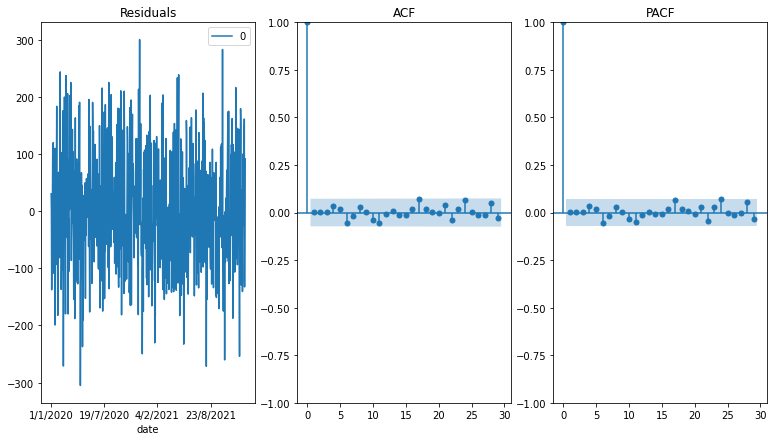

In [29]:
residuals = pd.DataFrame(result.resid)
fig, ax = plt.subplots(1,3)
residuals.plot(title="Residuals", ax=ax[0])
sm.graphics.plot_acf(residuals, ax=ax[1], title = 'ACF');
sm.graphics.plot_pacf(residuals, ax=ax[2], title = 'PACF');  

###  3) Residual Analysis

There is no clear pattern in the residual and the residuals have constant variance. The residual resemble a white noise time series. Also, there is no significant autocorrelation at any lag for both of the residual ACF/PACF.